Classical random walk in python

Text(0, 0.5, 'probability')

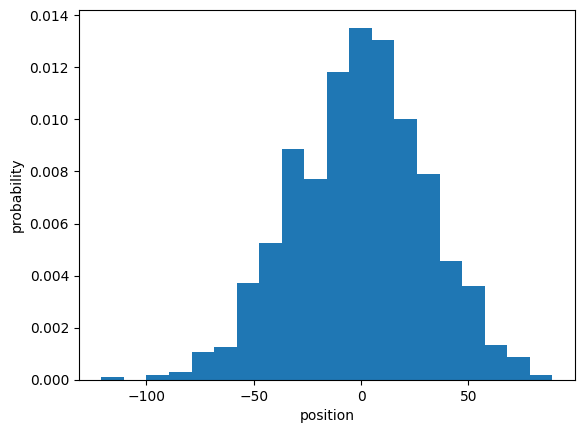

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_steps = 1000 #Essentially time
step_prob = 0.5 #Can step left or right equally
n_sim = 1000 #Perform the random walk 1000 times
#Make a new position vector. This will include all simulations
position = np.zeros((n_sim, n_steps))
#Loop through each simulation
for i in range(n_sim):
    #Loop through each step
    for j in range(1, n_steps):
        #Flip a coin.
        flip = np.random.rand()
        #Figure out how to step
        if flip < step_prob:
            step = -1
        else:
            step = 1
        #Update position
        position[i, j] = position[i, j-1] + step
#plot
plt.hist(position[:, -1], bins=20, density=True)
plt.xlabel('position')
plt.ylabel('probability')

Quantum random walk in python

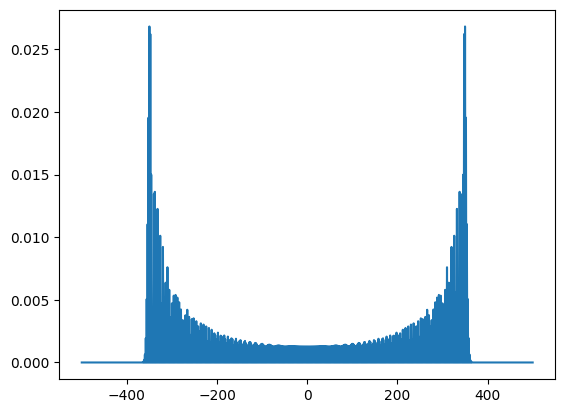

In [165]:
import math
import pylab

def probabilities(posn): #returns a list of the probabilies for each place
    return [sum([abs(amp)**2 for amp in place]) for place in posn]
def normalise(posn): #normalise function to normalise an input 1D line
    N = math.sqrt(sum(probabilities(posn)))
    return [[amp / N for amp in place] for place in posn]
def timestep(posn): #defines action of a timestep, i.e. a Hadamard gate on each element
    return normalise([[x[0]+x[1], x[0]-x[1]] for x in posn])
def shift(coin): #shift the up elements leftwards and the down elements rightwards
    newposn = [[0, 0] for i in range(len(coin))]
    for j in range(1, len(posn)-1):
        newposn[j+1][0] += coin[j][0]
        newposn[j-1][1] += coin[j][1]
    return normalise(newposn)
#initialise lists
min, max = -500, 501
posn = [[0, 0] for i in range(min, max)]
posn[-min] = [1 / math.sqrt(2), 1j / math.sqrt(2)]
#run for some steps
for time in range(-min):
    posn = shift(timestep(posn))

#plot
pylab.plot(range(min, max), probabilities(posn))
pylab.show()

Quantum random walk in Qiskit

#ลองทำวงจรเส้นตรง 10 qubit แล้วค่อยไปทำเป็นวงกลม 4 bit

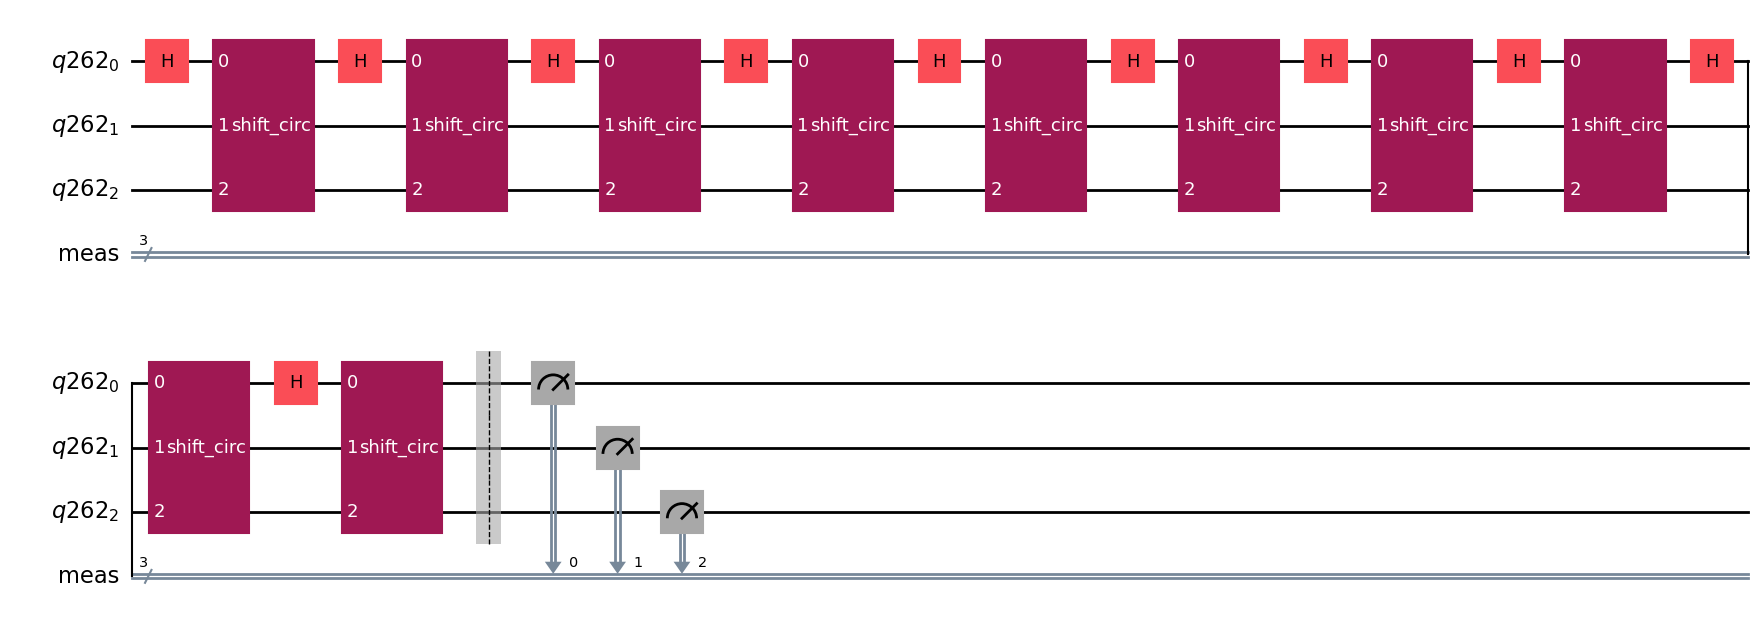

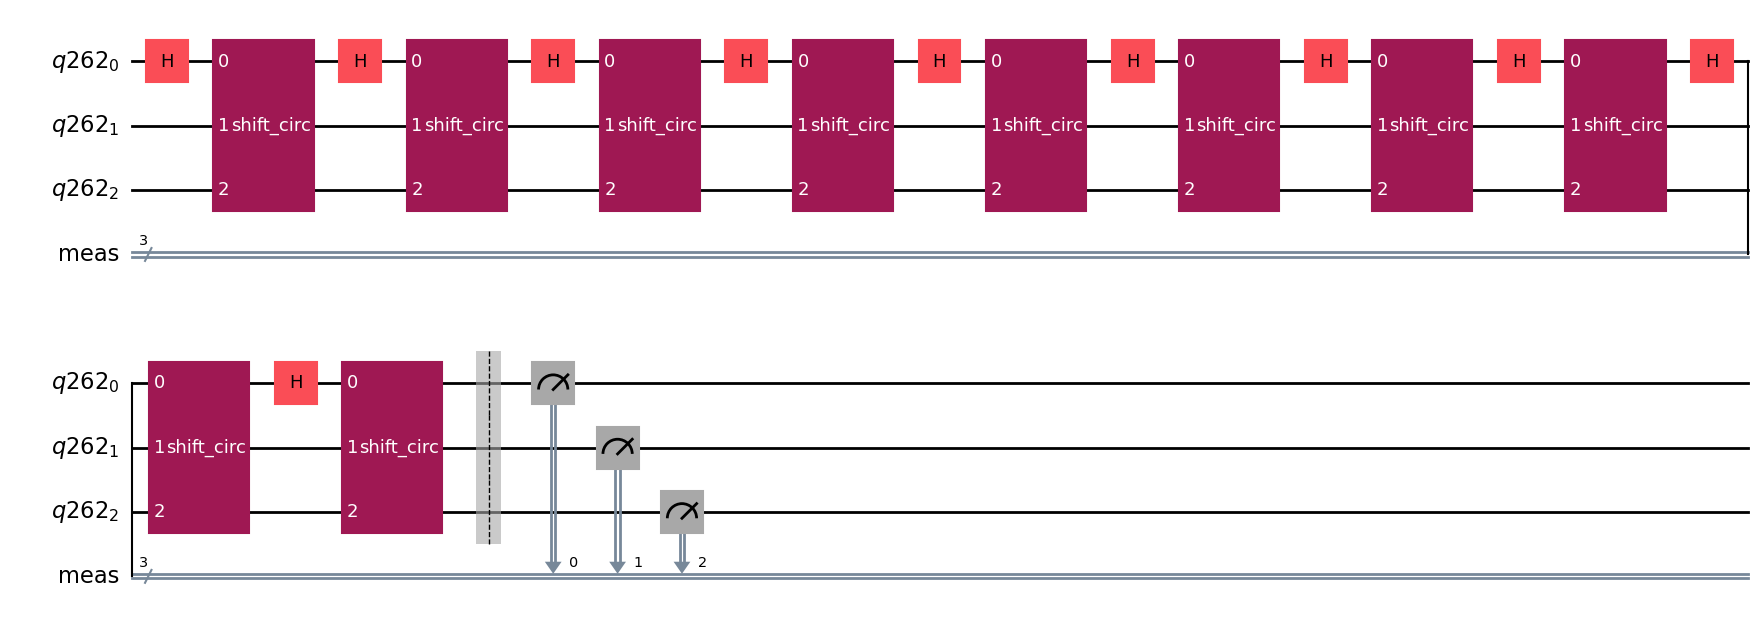

In [166]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import matplotlib.pyplot as plt

n_steps = 10 #number of steps
#defining the shift gate
shift_q = QuantumRegister(3) #3 qubit register
shift_circ = QuantumCircuit(shift_q, name='shift_circ') #circuit for shift operator
shift_circ.ccx(shift_q[0],shift_q[1], shift_q[2]) #toffoli gate
shift_circ.cx(shift_q[0],shift_q[1]) #CNOT gate
shift_circ.x(shift_q[0])
shift_circ.x(shift_q[1])
shift_circ.ccx(shift_q[0],shift_q[1], shift_q[2])
shift_circ.x(shift_q[1])
shift_circ.cx(shift_q[0],shift_q[1])
shift_gate = shift_circ.to_instruction() #convert the circuit to a gate

circ = QuantumCircuit(shift_q) #main circuit
for i in range(n_steps):
    circ.h(shift_q[0]) #coin step
    circ.append(shift_gate, [shift_q[0],shift_q[1],shift_q[2]]) #shift step
circ.measure_all()
circ.draw("mpl")

In [167]:
sampler = StatevectorSampler()
pub = (circ)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)
#00,01,10,11

{'100': 2498, '001': 2594, '101': 2483, '000': 2425}


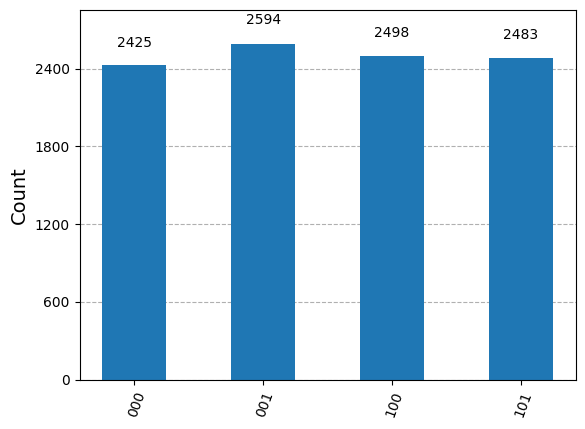

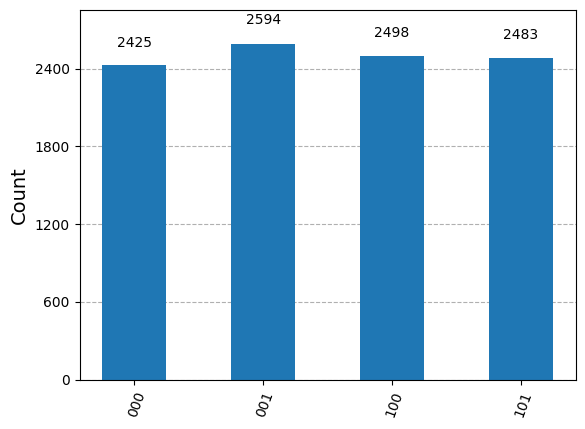

In [168]:
plot_histogram(counts_sampler)

Balanced coind walk

In [ ]:
import numpy as np
import networkx as nx
from networkx import hypercube_graph
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt


from numpy import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram, plot_bloch_vector

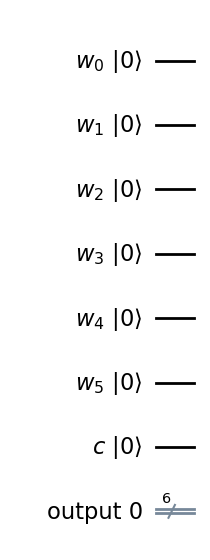

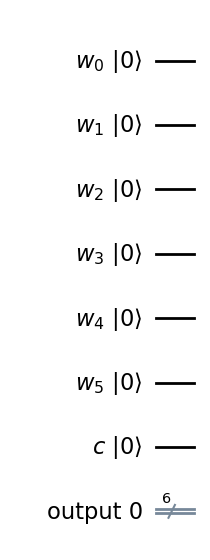

In [ ]:
def coined_walk_circuit(
    n_walker_qubits: int,
) -> tuple[QuantumCircuit, QuantumRegister, QuantumRegister, ClassicalRegister]:
    walker_r = QuantumRegister(n_walker_qubits, name="w")
    coin_r = QuantumRegister(1, name="c")  # The coin requires only one qubit
    classic_r = ClassicalRegister(n_walker_qubits, name="output")
    qc = QuantumCircuit(walker_r, coin_r, classic_r)
    return qc, walker_r, coin_r, classic_r

qc, _, _, _ = coined_walk_circuit(n_walker_qubits)
qc.draw(output="mpl", initial_state=True)

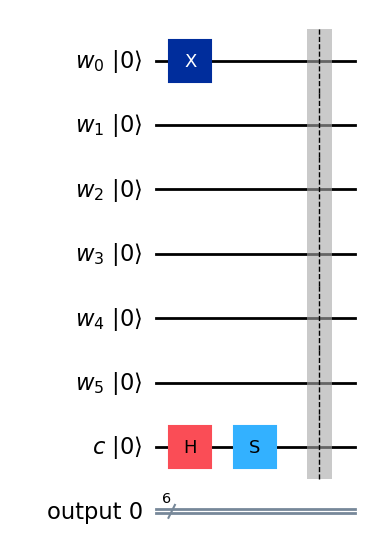

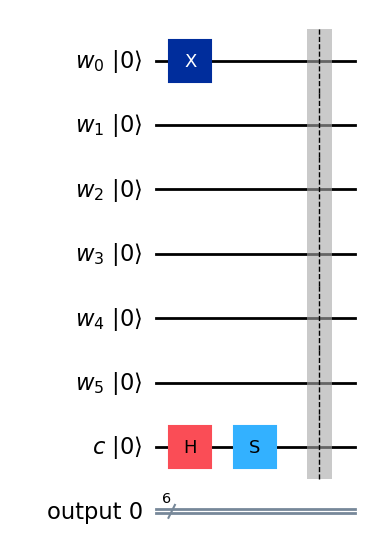

In [ ]:
def initialize_balance_coined_walk_circuit(
    qc: QuantumCircuit,
    walker_r: QuantumRegister,
    coin_r: QuantumRegister,
    initial_position: int,
    initial_coin_value: int,
) -> QuantumCircuit:
    if initial_coin_value == 1:
        qc.x(coin_r)
    qc.h(coin_r)
    qc.s(coin_r)
    for i in range(n_walker_qubits):
        if initial_position & (1 << i):
            qc.x(walker_r[n_walker_qubits - i - 1])
    qc.barrier()
    return qc
qc, walker_r, coin_r, _ = coined_walk_circuit(n_walker_qubits)
qc = initialize_balance_coined_walk_circuit(
    qc, walker_r, coin_r, initial_position, initial_coin_value
)
qc.draw(output="mpl", initial_state=True)

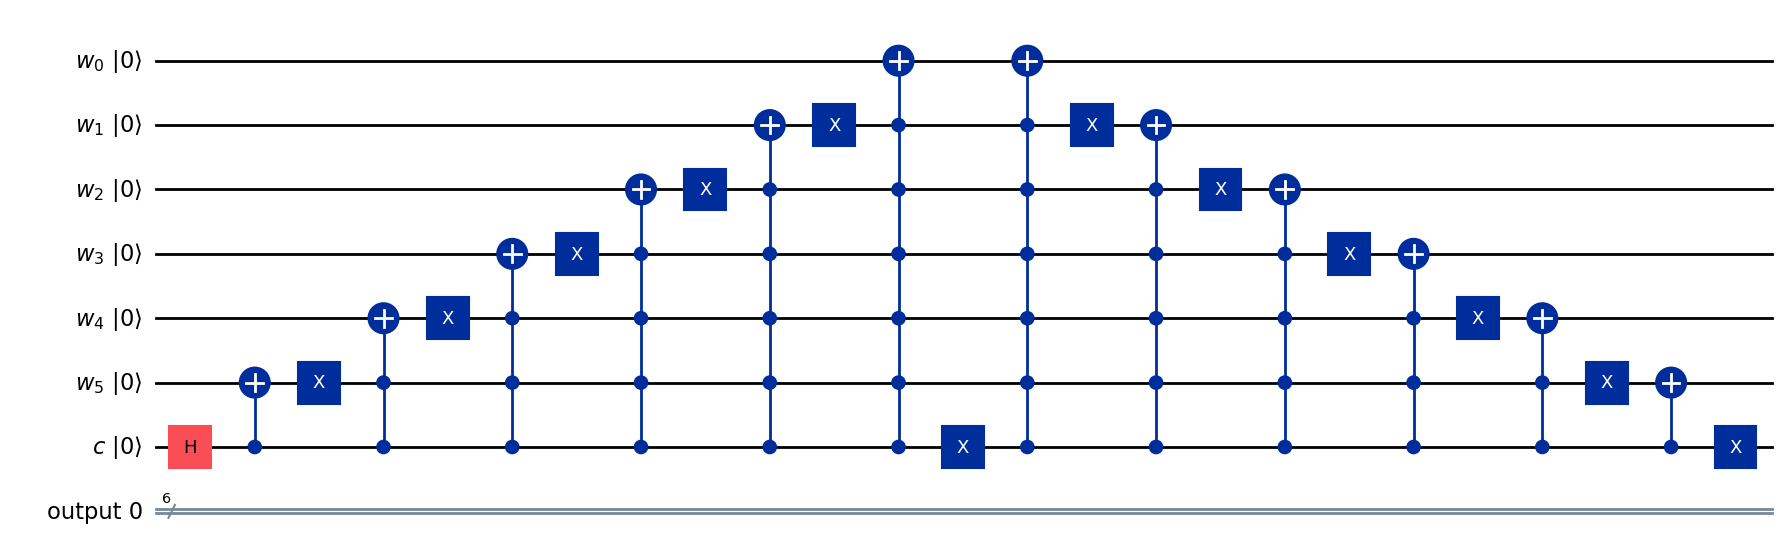

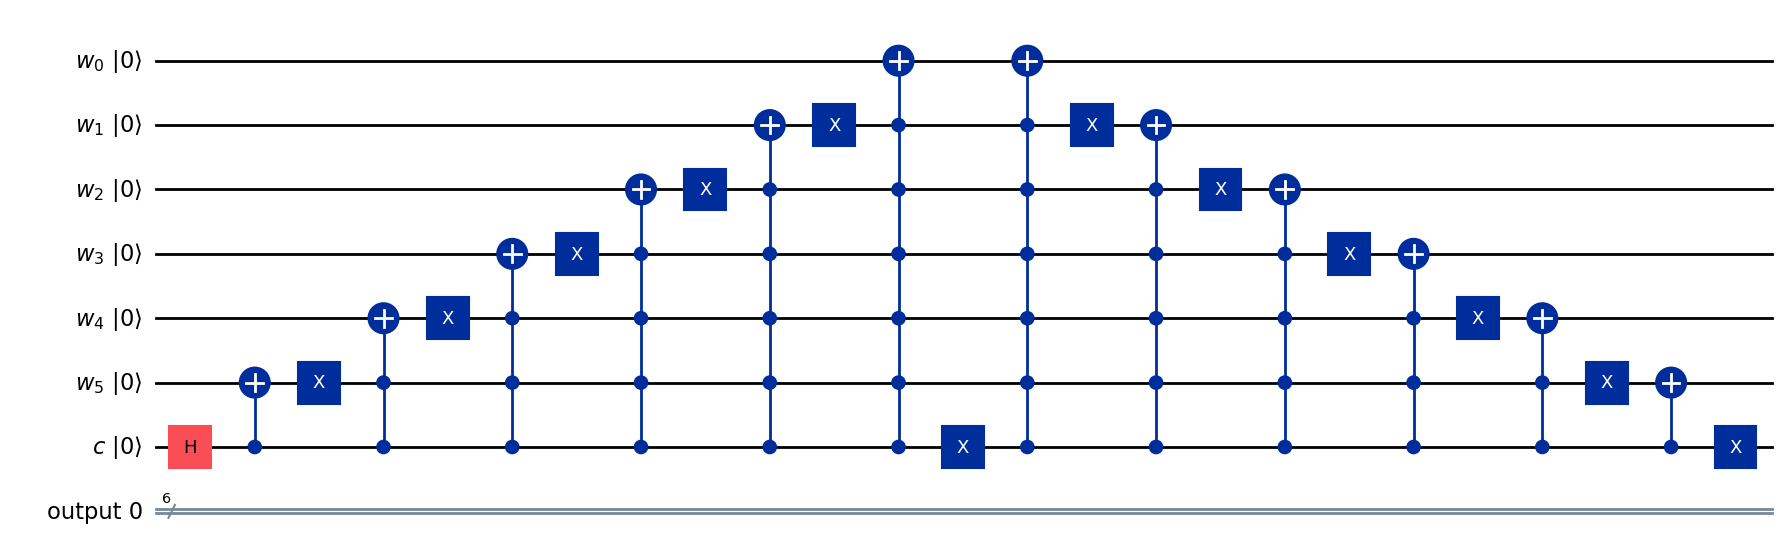

In [ ]:
def coined_walk_step(
    qc: QuantumCircuit, walker_r: QuantumRegister, coin_r: QuantumRegister
) -> QuantumCircuit:
    # "Flip" the coin vector
    qc.h(coin_r)
    # Implement the Addition Operator
    for i in reversed(range(len(walker_r))):
        # Qubits with less significant bits than the current one
        controls = [walker_r[v] for v in range(len(walker_r) - 1, i, -1)]
        controls.append(coin_r)  # The coin qubit is also used as a control
        qc.mcx(controls, walker_r[i])  # Multi-controlled X gate
        if i != 0:
            qc.x(walker_r[i])  # Flip the qubit
    # Switch the coin vector
    qc.x(coin_r)
    # Implement the Subtraction Operator
    for i in range(len(walker_r)):
        if i != 0:
            qc.x(walker_r[i])  # Reverse the flip
        # Qubits with less significant bits than the current one
        controls = [walker_r[v] for v in range(len(walker_r) - 1, i, -1)]
        controls.append(coin_r)  # The coin qubit is also used as a control
        qc.mcx(controls, walker_r[i])  # Multi-controlled X gate
    # Revert the switch of the coin vector
    qc.x(coin_r)
    return qc
qc, walker_r, coin_r, _ = coined_walk_circuit(n_walker_qubits)
qc = coined_walk_step(qc, walker_r, coin_r)
qc.draw(output="mpl", initial_state=True)

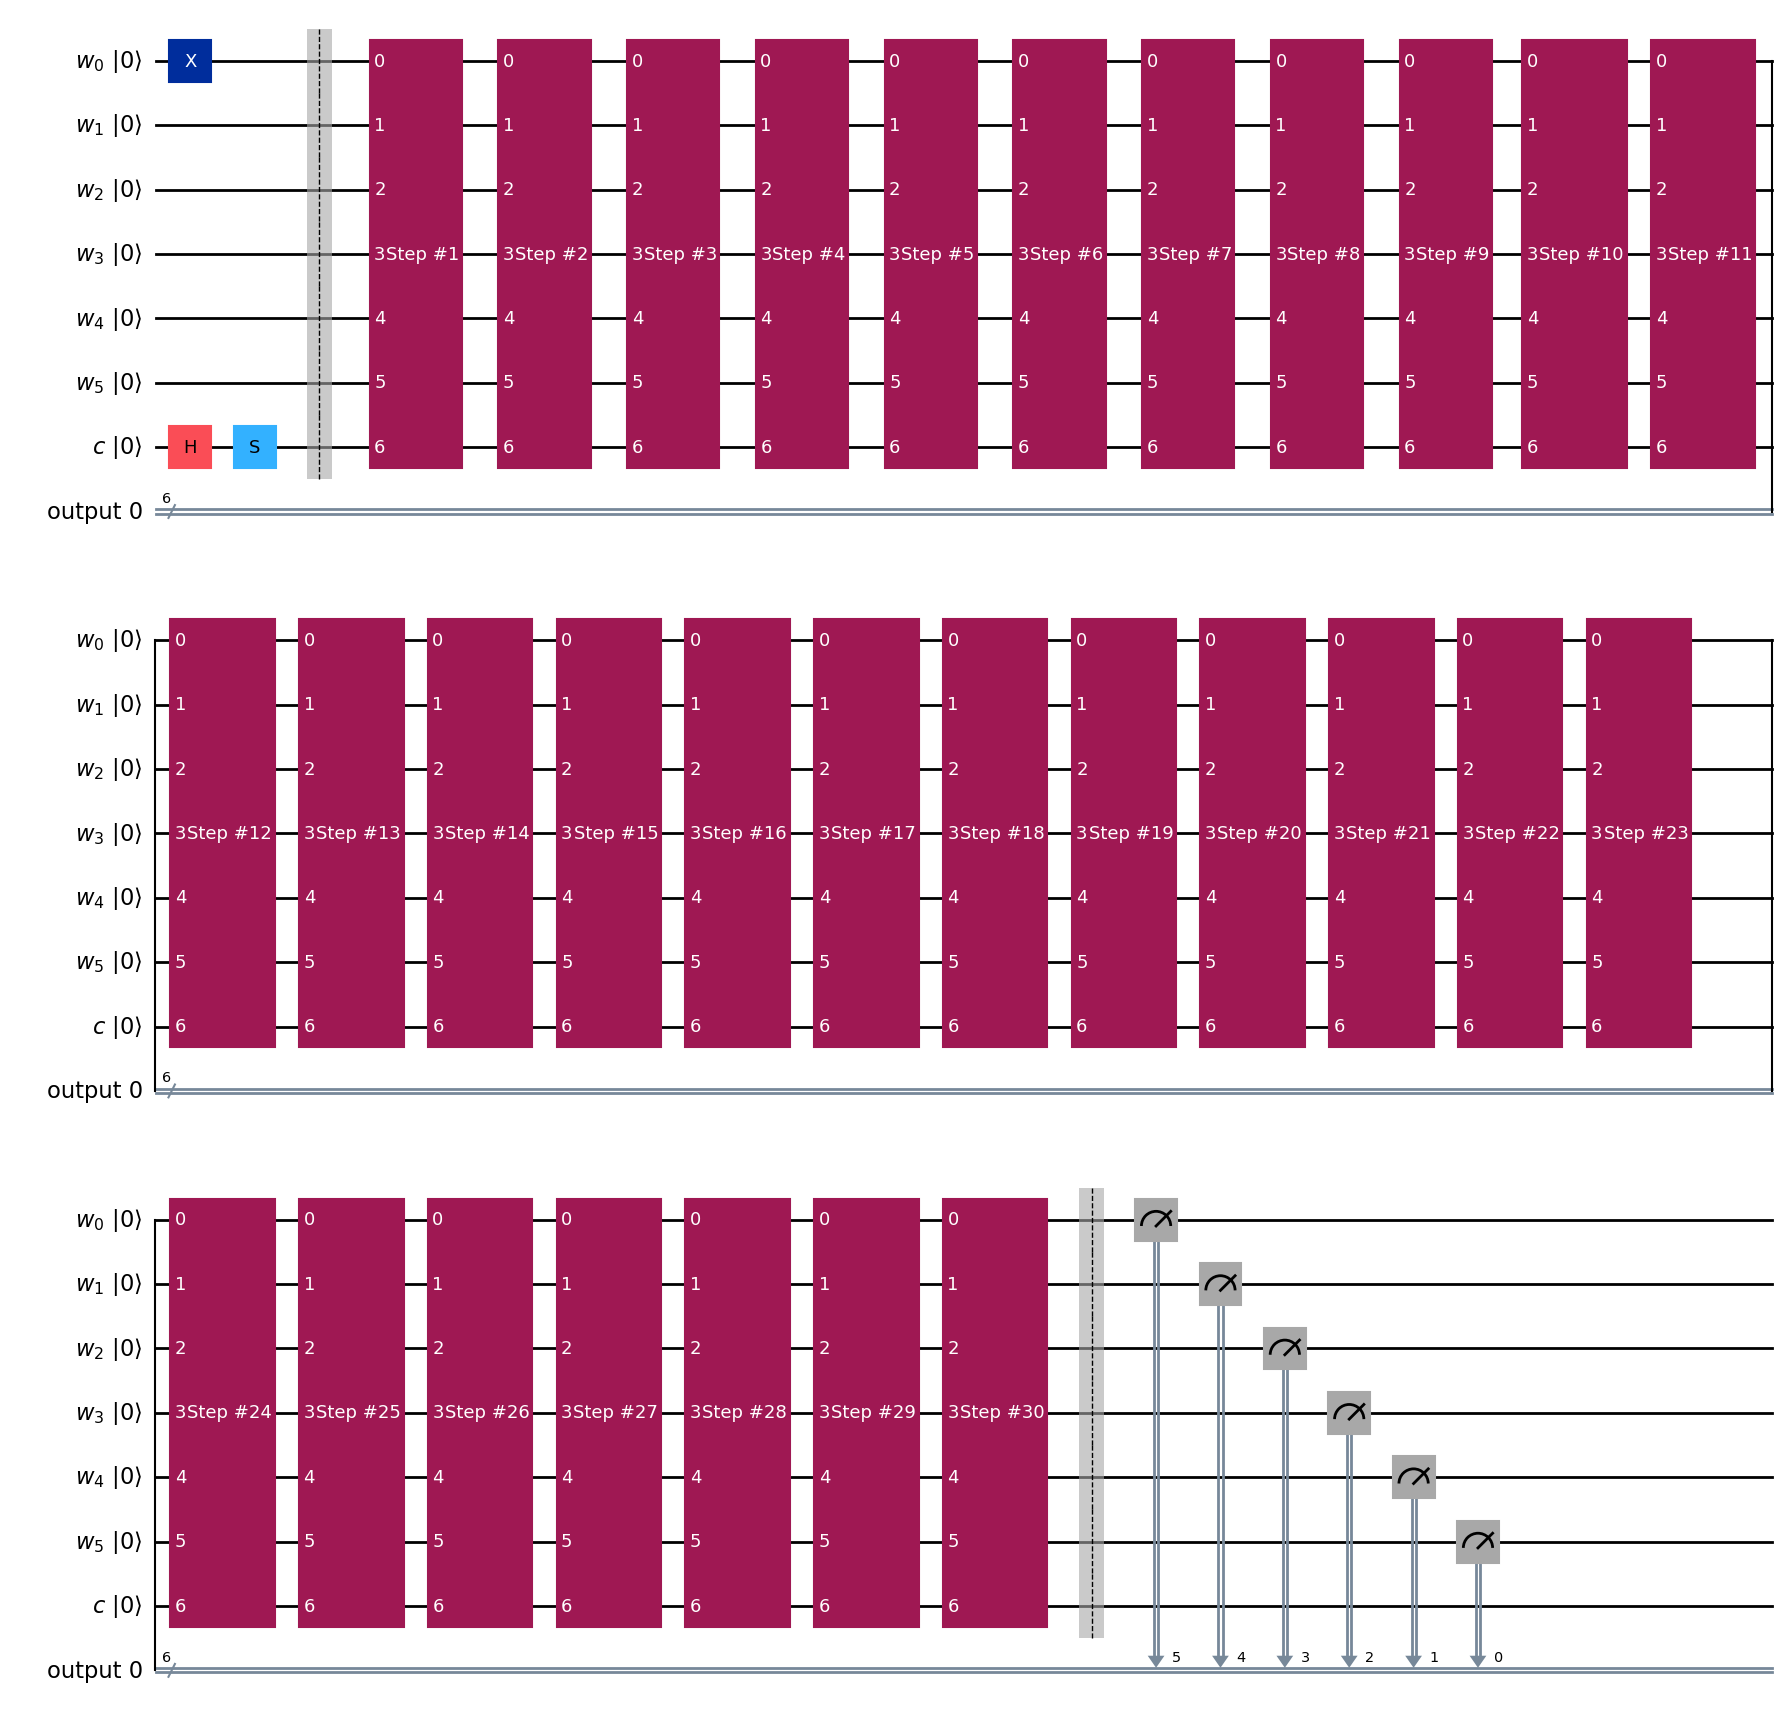

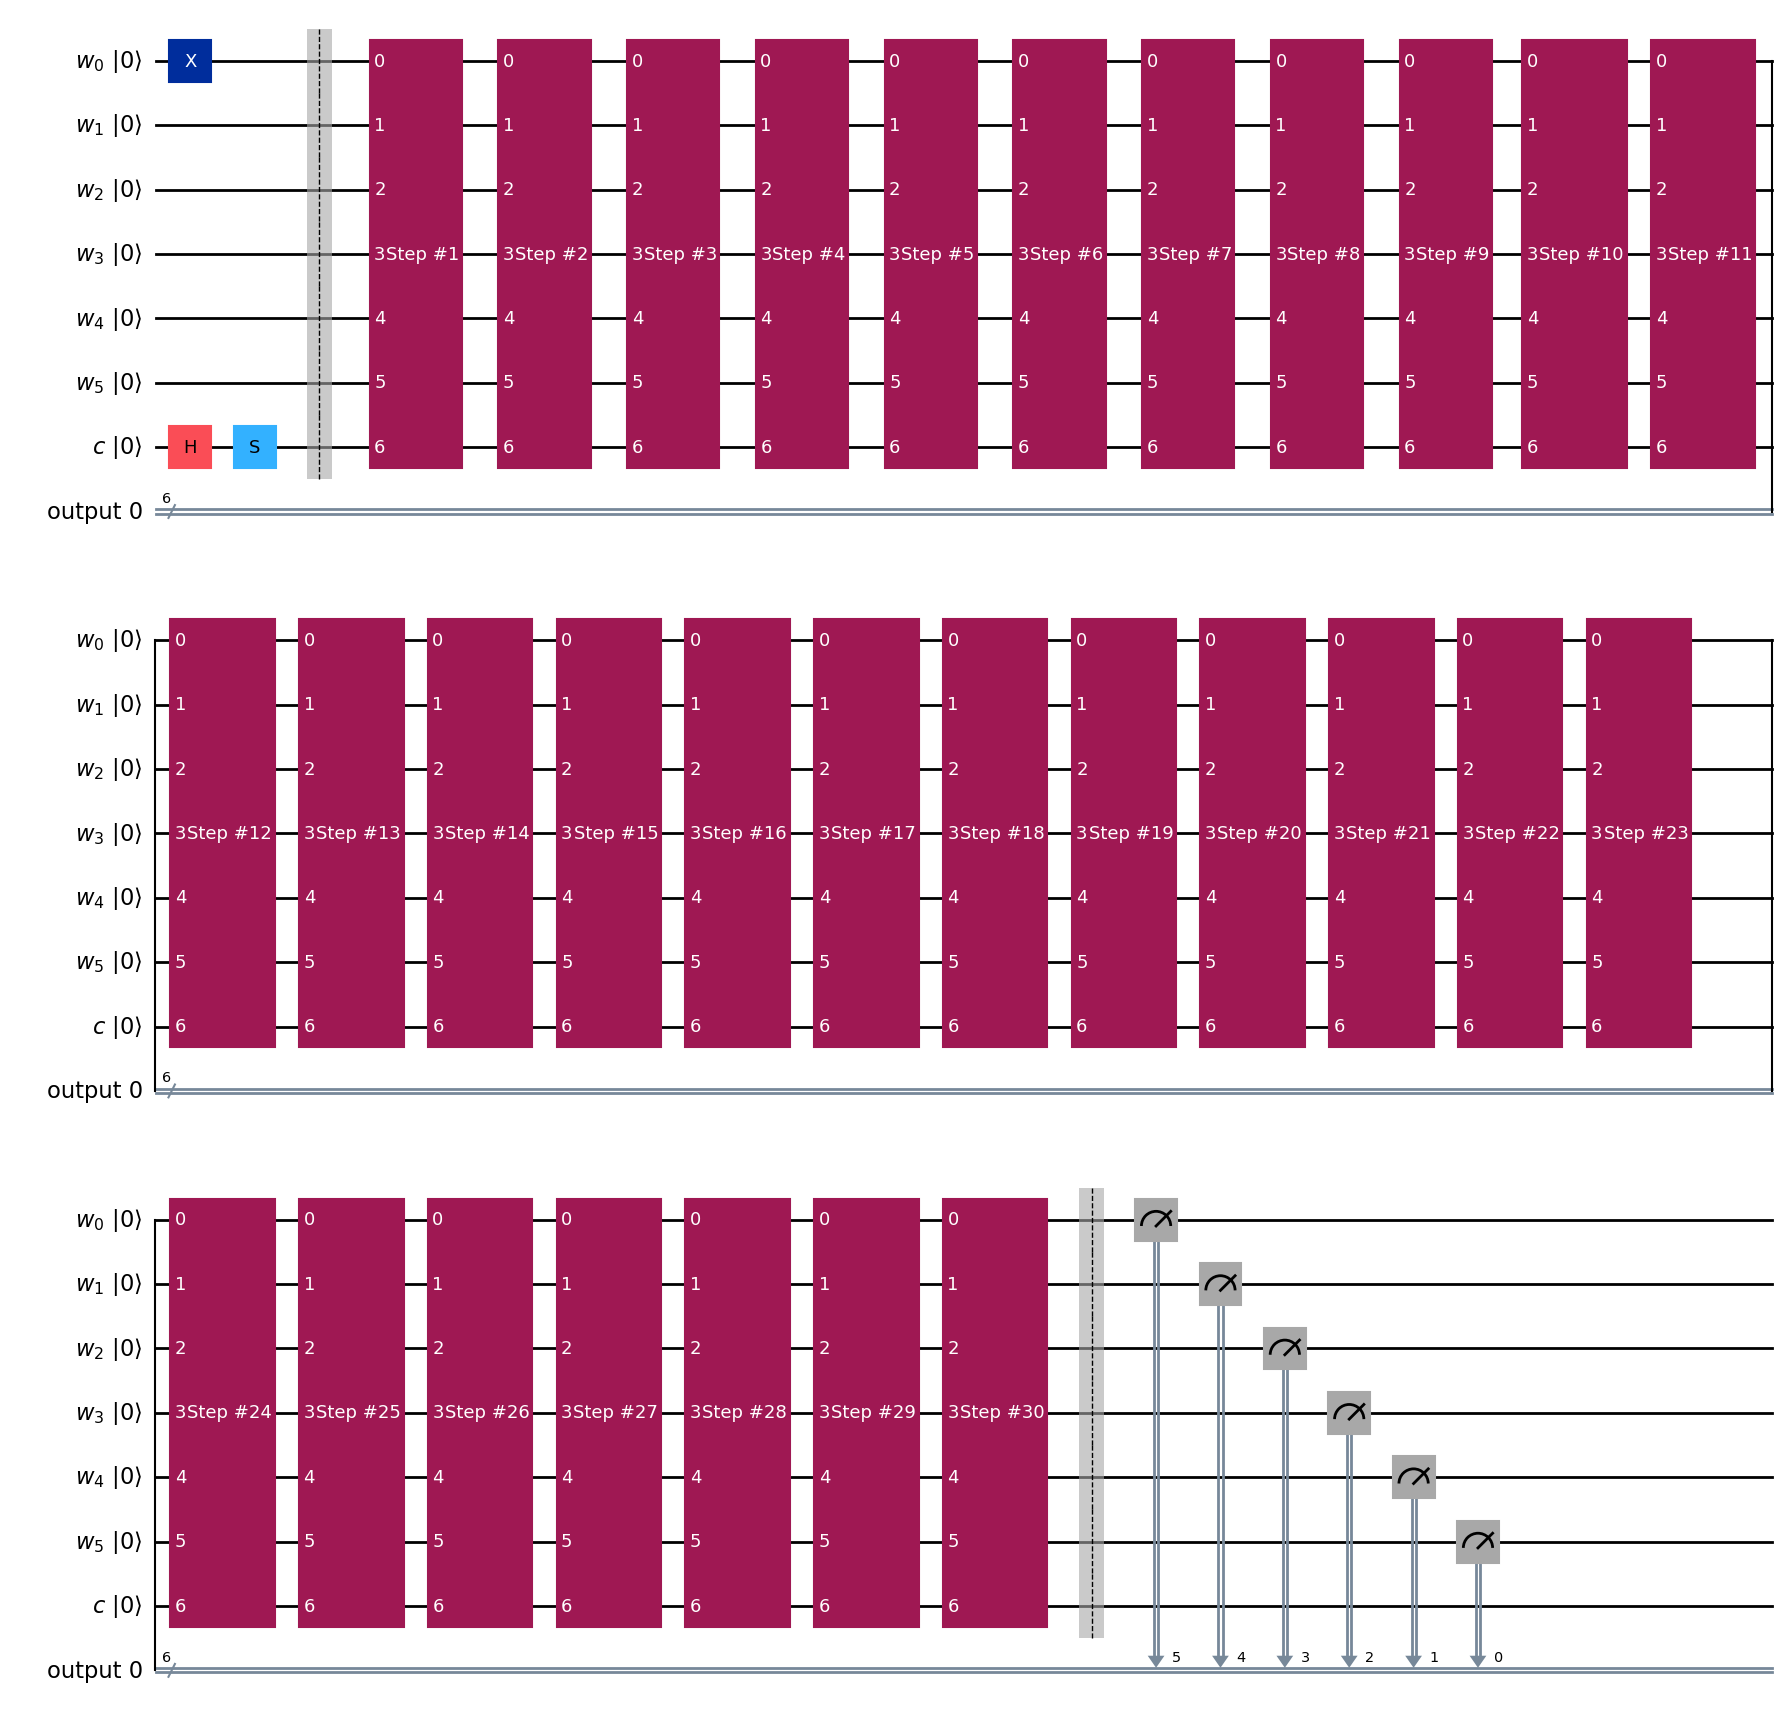

In [ ]:
def coined_walk(
    n_walker_qubits: int,
    n_steps: int,
    initial_position: int,
    initial_coin_value: int,
    init_func: callable,
) -> QuantumCircuit:
    qc, walker_r, coin_r, classic_r = coined_walk_circuit(n_walker_qubits)
    qc = init_func(qc, walker_r, coin_r, initial_position, initial_coin_value)
    for i in range(n_steps):
        step_gate = coined_walk_step(QuantumCircuit(walker_r, coin_r), walker_r, coin_r)
        qc.append(step_gate.to_gate(label=f"Step #{i + 1}"), walker_r[:] + coin_r[:])
    qc.barrier()
    qc.measure(walker_r, reversed(classic_r))
    return qc
qc = coined_walk(
    n_walker_qubits,
    n_steps,
    initial_position,
    initial_coin_value,
    initialize_balance_coined_walk_circuit,
)
qc.draw(output="mpl", initial_state=True)

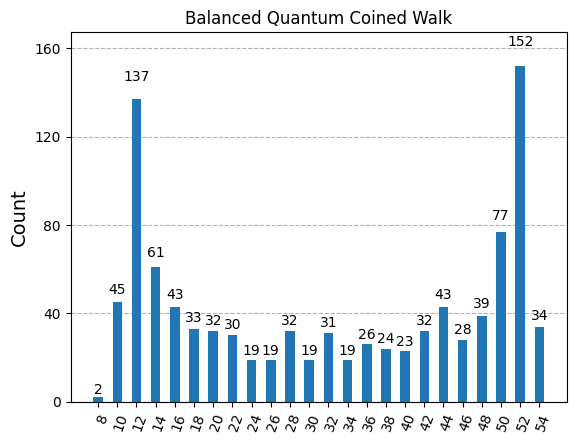

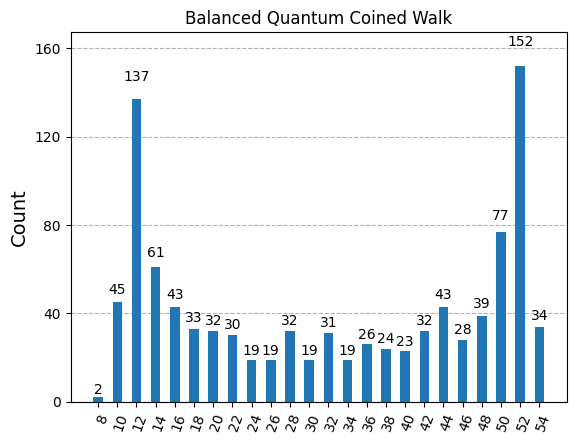

In [173]:
n_walker_qubits = 6  # The number of qubits used to represent the position of the walker
n_steps = 30  # The number of steps of the quantum walk
initial_position = 2 ** (
    n_walker_qubits - 1
)  # The initial position of the walker is the middle of all possible positions
initial_coin_value = 0  # The initial value of the coin is 0
n_runs = 1000  # The number of runs of the quantum circuit

qc = coined_walk(
    n_walker_qubits,
    n_steps,
    initial_position,
    initial_coin_value,
    initialize_balance_coined_walk_circuit,
)

def plot_results(qc: QuantumCircuit, n_runs: int, title: str):
    simulator: backend = AerSimulator()
    transpiled_qc = transpile(qc, simulator)
    results = simulator.run(transpiled_qc, shots=n_runs).result()
    counts = results.get_counts(transpiled_qc)
    counts = {int(k, 2): v for k, v in counts.items()}
    return plot_histogram(counts, title=title)
plot_results(qc, n_runs, "Balanced Quantum Coined Walk")